# Mounting the datasets from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_dir = '/content/drive/MyDrive/colab/drowsiness_dataset/'
yawn_training_set = '/content/drive/MyDrive/colab/drowsiness_dataset/train/yawning_detection'
yawn_testing_set = '/content/drive/MyDrive/colab/drowsiness_dataset/test/yawning_detection'

 # Loading Libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Loading and Preprocessing Data

In [ ]:
IMG_SIZE = (224,224)

# Create an ImageDataGenerator for training with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.2, 1.0],
    validation_split=0.2  # 20% of training data for validation
)

# Create an ImageDataGenerator for test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test set

# Load and preprocess training data (80% for training)
train_data = train_datagen.flow_from_directory(
    yawn_training_set,
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='binary',
    subset='training'  # Specify subset as training
)

# Load and preprocess validation data (20% for validation)
validation_data = train_datagen.flow_from_directory(
    yawn_training_set,
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='binary',
    subset='validation'  # Specify subset as validation
)

# Load and preprocess test data
test_data = test_datagen.flow_from_directory(
    yawn_testing_set,
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='binary'
)


Found 987 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Found 215 images belonging to 2 classes.


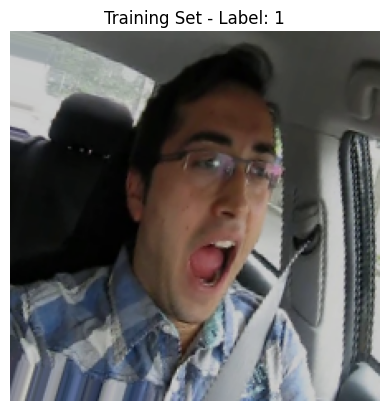

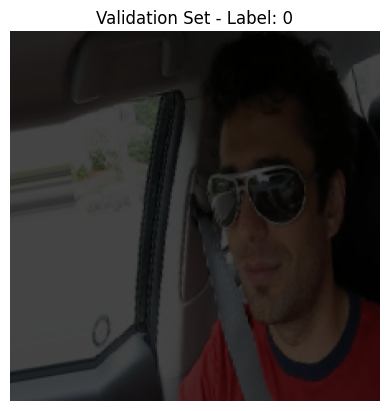

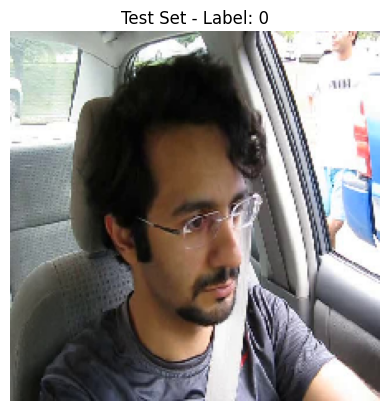

In [ ]:
# Function to display an image and its label
def show_image(data, title):
    # Get a batch of images and labels
    images, labels = next(data)

    # Convert from (batch_size, height, width, channels) to (height, width, channels)
    image = images[0]  # First image in the batch
    label = labels[0]  # First label in the batch

    # Display the image
    plt.imshow(image)
    plt.title(f"{title} - Label: {int(label)}")  # Display label (0 or 1 for binary classification)
    plt.axis('off')
    plt.show()

# Display one image from the training set
show_image(train_data, "Training Set")

# Display one image from the validation set
show_image(validation_data, "Validation Set")

# Display one image from the test set
show_image(test_data, "Test Set")


# Building MobileNetV2 Models With different epochs

# Model Training with 20 epochs

## Initialize the model

In [ ]:

# Load the pre-trained MobileNetV2 model, excluding the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base layers of MobileNetV2
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduce spatial dimensions
    Dropout(0.5),  # Add dropout to reduce overfitting
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])


_ = model(tf.zeros((1, 224, 224, 3)))
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (1, 7, 7, 1280)             │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (1, 1280)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 1280)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 1)                      │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training and saving the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping and model checkpoint
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/colab/mobileNet_yawn_best_weights_only.weights.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=True)  # Save only the weights during training

# Train the model, using the validation data instead of the test data for validation
history = model.fit(
    train_data,               # Training data
    epochs=20,                # Number of epochs
    validation_data=validation_data,  # Use validation set here
    callbacks=[early_stop, checkpoint]
)




Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 257s 10s/step - binary_accuracy: 0.5421 - loss: 0.8078 - val_binary_accuracy: 0.4675 - val_loss: 0.7920
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 972ms/step - binary_accuracy: 0.6266 - loss: 0.7263 - val_binary_accuracy: 0.5081 - val_loss: 0.7122
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - binary_accuracy: 0.6112 - loss: 0.7007 - val_binary_accuracy: 0.5163 - val_loss: 0.7423
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 991ms/step - binary_accuracy: 0.6009 - loss: 0.6941 - val_binary_accuracy: 0.5976 - val_loss: 0.6839
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 985ms/step - binary_accuracy: 0.6236 - loss: 0.6610 - val_binary_accuracy: 0.5691 - val_loss: 0.6795
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - binary_accuracy: 0.6433 - loss: 0.6369 - val_binary_accuracy: 0.5203 - val_loss: 0.6623
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 962ms/step - binary_accuracy: 0.6352 - loss: 0.6171 - val_binary_accuracy: 0.6260 - val_loss: 0.6445
Epoch 8/20
16/16 

In [ ]:
# After training completes, load the best weights saved by the checkpoint
model.load_weights('/content/drive/MyDrive/colab/mobileNet_yawn_best_weights_only.weights.h5')

# Now, save the entire model with the best weights and architecture
model.save('/content/drive/MyDrive/colab/mobileNet_yawn_best_full_model.keras')

## Define architecture for testing

In [ ]:
# Load the pre-trained MobileNetV2 model, excluding the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base layers of MobileNetV2
base_model.trainable = False

# Build the model
model_test = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduce spatial dimensions
    Dropout(0.5),  # Add dropout to reduce overfitting
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model with Adam optimizer and binary crossentropy loss
model_test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

_ = model(tf.zeros((1, 224, 224, 3)))
model_test.summary()

## Load saved model weights

In [ ]:
model_test.load_weights('/content/drive/MyDrive/colab/mobileNet_yawn_best_weights_only.weights.h5')

## Testing model  accuracy and loss

In [ ]:
# After loading the weights, proceed with evaluation or inference
test_loss, test_accuracy = model_test.evaluate(test_data)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


## Observing Validation and Training loss

<Figure size 800x600 with 0 Axes>

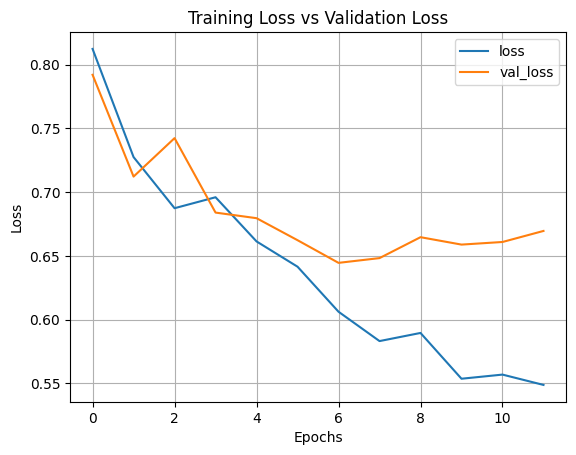

<Figure size 800x600 with 0 Axes>

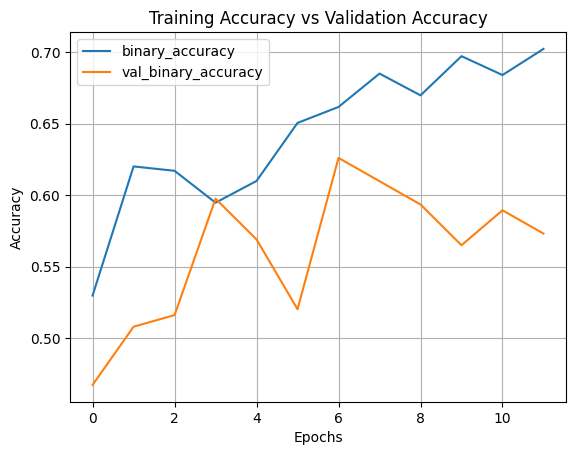

Minimum validation loss: 0.6445049047470093


In [ ]:
# Convert the history object to a DataFrame
history_df = pd.DataFrame(history.history)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Print minimum validation loss
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# Model Training with 30 Epochs

## Initialize the model

In [ ]:
# Load the pre-trained MobileNetV2 model, excluding the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base layers of MobileNetV2
base_model.trainable = False

# Build the model
model2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduce spatial dimensions
    Dropout(0.5),  # Add dropout to reduce overfitting
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model with Adam optimizer and binary crossentropy loss
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

_ = model2(tf.zeros((1, 224, 224, 3)))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (1, 7, 7, 1280)             │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (1, 1280)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 1280)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training and saving the model

In [ ]:
# Define early stopping and model checkpoint
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/colab/mobileNet_yawn_thirty_best_weights_only.weights.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=True)  # Save only the weights during training

# Train the model, using the validation data instead of the test data for validation
history2 = model2.fit(
    train_data,               # Training data
    epochs=30,                # Number of epochs
    validation_data=validation_data,  # Use validation set here
    callbacks=[early_stop, checkpoint]
)




Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - binary_accuracy: 0.5798 - loss: 0.7605 - val_binary_accuracy: 0.5854 - val_loss: 0.6568
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - binary_accuracy: 0.5747 - loss: 0.7048 - val_binary_accuracy: 0.6057 - val_loss: 0.6323
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - binary_accuracy: 0.5856 - loss: 0.7235 - val_binary_accuracy: 0.6057 - val_loss: 0.6231
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 977ms/step - binary_accuracy: 0.5979 - loss: 0.6825 - val_binary_accuracy: 0.6260 - val_loss: 0.6286
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 974ms/step - binary_accuracy: 0.6534 - loss: 0.6396 - val_binary_accuracy: 0.6220 - val_loss: 0.6169
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 929ms/step - binary_accuracy: 0.6666 - loss: 0.6153 - val_binary_accuracy: 0.5976 - val_loss: 0.6429
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 917ms/step - binary_accuracy: 0.6574 - loss: 0.6239 - val_binary_accuracy: 0.6341 - val_loss: 0.6483
Epoch 8/

In [ ]:
# After training completes, load the best weights saved by the checkpoint
model2.load_weights('/content/drive/MyDrive/colab/mobileNet_yawn_thirty_best_weights_only.weights.h5')

# Now, save the entire model with the best weights and architecture
model2.save('/content/drive/MyDrive/colab/mobileNet_yawn_thirty_best_full_model.keras')

## Define architecture for testing

In [ ]:
# Load the pre-trained MobileNetV2 model, excluding the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base layers of MobileNetV2
base_model.trainable = False

# Build the model
model2_test = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduce spatial dimensions
    Dropout(0.5),  # Add dropout to reduce overfitting
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model with Adam optimizer and binary crossentropy loss
model2_test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

_ = model2_test(tf.zeros((1, 224, 224, 3)))
model2_test.summary()

## Load saved model weights

In [ ]:
model2_test.load_weights('/content/drive/MyDrive/colab/mobileNet_yawn_thirty_best_weights_only.weights.h5')

## Observing validataion and training loss

<Figure size 800x600 with 0 Axes>

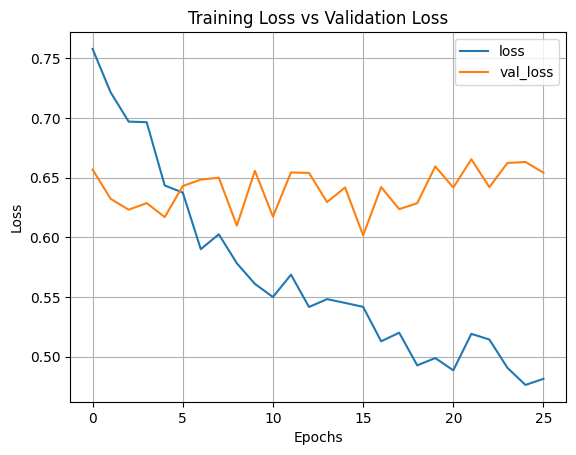

<Figure size 800x600 with 0 Axes>

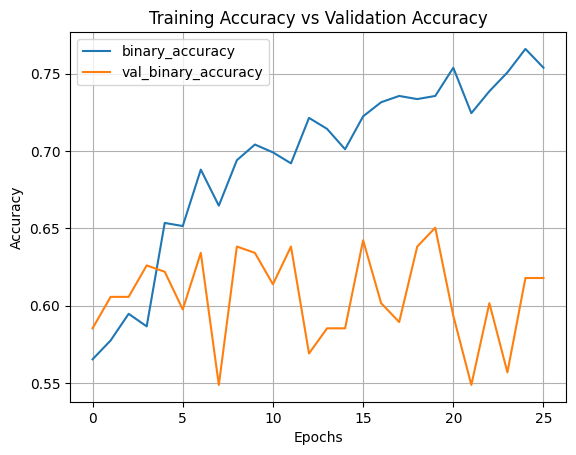

Minimum validation loss: 0.6015518307685852


In [ ]:
# Convert the history object to a DataFrame
history_df2 = pd.DataFrame(history2.history)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
history_df2.loc[:, ['loss', 'val_loss']].plot()
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
history_df2.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Print minimum validation loss
print("Minimum validation loss: {}".format(history_df2['val_loss'].min()))

## Testing model accuracy and loss

In [ ]:
# After loading the weights, proceed with evaluation or inference
test_loss, test_accuracy = model2_test.evaluate(test_data)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# Model Training with 50 Epochs

## Initialize the model

In [ ]:
# Load the pre-trained MobileNetV2 model, excluding the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base layers of MobileNetV2
base_model.trainable = False

# Build the model
model3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduce spatial dimensions
    Dropout(0.5),  # Add dropout to reduce overfitting
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model with Adam optimizer and binary crossentropy loss
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

_ = model3(tf.zeros((1, 224, 224, 3)))
model3.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (1, 7, 7, 1280)             │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (1, 1280)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 1280)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 1)                      │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Load previous best weights

In [ ]:
model3.load_weights('/content/drive/MyDrive/colab/mobileNet_yawn_thirty_best_weights_only.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Training and Saving the model

In [ ]:
# Define early stopping and model checkpoint
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/colab/mobileNet_yawn_fifty_best_weights_only.weights.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=True)  # Save only the weights during training

# Train the model, using the validation data instead of the test data for validation
history3 = model3.fit(
    train_data,               # Training data
    epochs=50,                # Number of epochs
    validation_data=validation_data,  # Use validation set here
    callbacks=[early_stop, checkpoint]
)




Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 545s 23s/step - binary_accuracy: 0.6791 - loss: 0.5585 - val_binary_accuracy: 0.5325 - val_loss: 0.6878
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - binary_accuracy: 0.6707 - loss: 0.5691 - val_binary_accuracy: 0.5569 - val_loss: 0.6553
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 967ms/step - binary_accuracy: 0.7234 - loss: 0.5255 - val_binary_accuracy: 0.6301 - val_loss: 0.6708
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - binary_accuracy: 0.7463 - loss: 0.4908 - val_binary_accuracy: 0.5691 - val_loss: 0.6446
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - binary_accuracy: 0.7369 - loss: 0.5113 - val_binary_accuracy: 0.6057 - val_loss: 0.6767
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 992ms/step - binary_accuracy: 0.7631 - loss: 0.4922 - val_binary_accuracy: 0.6423 - val_loss: 0.6340
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 909ms/step - binary_accuracy: 0.7256 - loss: 0.4994 - val_binary_accuracy: 0.6382 - val_loss: 0.6587
Epoch 8/50
16/16 ━━━

In [ ]:
# After training completes, load the best weights saved by the checkpoint
model3.load_weights('/content/drive/MyDrive/colab/mobileNet_yawn_fifty_best_weights_only.weights.h5')

# Now, save the entire model with the best weights and architecture
model3.save('/content/drive/MyDrive/colab/mobileNet_yawn_fifty_best_full_model.keras')

## Define Architecture For Testing

In [ ]:
# Load the pre-trained MobileNetV2 model, excluding the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base layers of MobileNetV2
base_model.trainable = False

# Build the model
model3_test = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduce spatial dimensions
    Dropout(0.5),  # Add dropout to reduce overfitting
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model with Adam optimizer and binary crossentropy loss
model3_test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

_ = model3_test(tf.zeros((1, 224, 224, 3)))
model3_test.summary()

## Load saved model weights

In [ ]:
model3_test.load_weights('/content/drive/MyDrive/colab/mobileNet_yawn_thirty_best_weights_only.weights.h5')

## Observing validation and training loss

<Figure size 800x600 with 0 Axes>

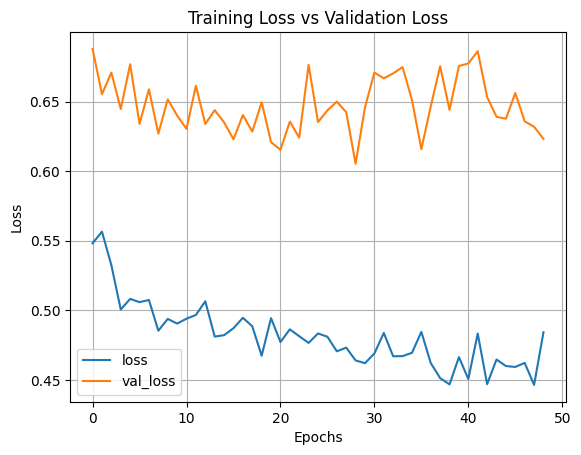

<Figure size 800x600 with 0 Axes>

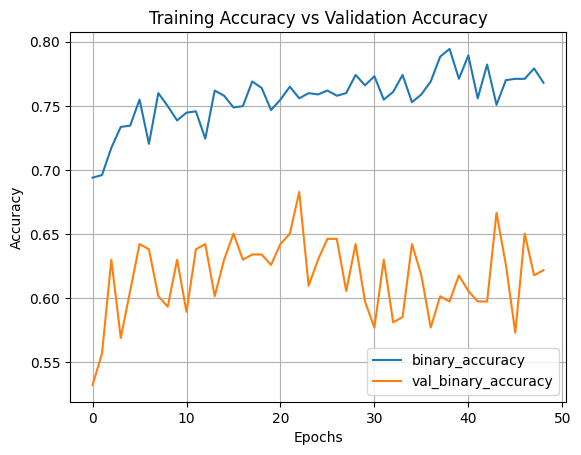

Minimum validation loss: 0.605339765548706


In [ ]:
# Convert the history object to a DataFrame
history_df3 = pd.DataFrame(history3.history)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
history_df3.loc[:, ['loss', 'val_loss']].plot()
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
history_df3.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Print minimum validation loss
print("Minimum validation loss: {}".format(history_df3['val_loss'].min()))

## Testing model accuracy and loss

In [ ]:
# After loading the weights, proceed with evaluation or inference
test_loss, test_accuracy = model3_test.evaluate(test_data)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# Testing Accuracies


In [4]:

# Load the pre-trained MobileNetV2 model, excluding the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base layers of MobileNetV2
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduce spatial dimensions
    Dropout(0.5),  # Add dropout to reduce overfitting
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])


_ = model(tf.zeros((1, 224, 224, 3)))
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (1, 7, 7, 1280)             │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (1, 1280)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 1280)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 1)                      │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import MobileNetV2

# Define paths to your saved models
model_paths = [
    '/content/drive/MyDrive/colab/mobileNet_yawn_best_weights_only.weights.h5',
    '/content/drive/MyDrive/colab/mobileNet_yawn_thirty_best_weights_only.weights.h5',
    '/content/drive/MyDrive/colab/mobileNet_yawn_fifty_best_weights_only.weights.h5'
]

# Image size to match the model input
IMG_SIZE = (224, 224)

# Create an ImageDataGenerator for test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess test data
test_data = test_datagen.flow_from_directory(
    yawn_testing_set,
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='binary'
)

# Function to evaluate a model on test data and print accuracy
def evaluate_model(model_path, test_data):
    # Load the saved model
    model.load_weights(model_path)

    # Evaluate the model on the test dataset
    loss, accuracy = model.evaluate(test_data)

    # Print the accuracy
    print(f'Model: {model_path}')
    print(f'Test Accuracy: {accuracy:.4f}')
    print('-' * 30)

# Evaluate each model
for model_path in model_paths:
    evaluate_model(model_path, test_data)

Found 215 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - binary_accuracy: 0.6963 - loss: 0.5357
Model: /content/drive/MyDrive/colab/mobileNet_yawn_best_weights_only.weights.h5
Test Accuracy: 0.6651
------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - binary_accuracy: 0.7025 - loss: 0.5184
Model: /content/drive/MyDrive/colab/mobileNet_yawn_thirty_best_weights_only.weights.h5
Test Accuracy: 0.6977
------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - binary_accuracy: 0.7431 - loss: 0.4880
Model: /content/drive/MyDrive/colab/mobileNet_yawn_fifty_best_weights_only.weights.h5
Test Accuracy: 0.7535
------------------------------


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load a new image for prediction
img_path = 'path_to_image.jpg'
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict whether eyes are open or closed
prediction = model.predict(img_array)
if prediction > 0.5:
    print("Driver yawning")
else:
    print("Driver not yawning")


In [ ]:
b